# AWN3 Linguistic & Logical Issues Analysis

This notebook provides a comprehensive analysis of potential issues in the AWN3 Arabic WordNet from linguistic and logical perspectives.

## Issues Categories
1. **Critical Issues** - Empty synsets, missing data
2. **Definition Quality** - Short, circular, or problematic definitions
3. **Example Quality** - Issues with usage examples
4. **Structural Issues** - Taxonomy problems, orphans
5. **Linguistic Issues** - POS problems, diacritization
6. **Cross-lingual Alignment** - Mismatches with English WordNet

## Setup

In [1]:
import wn
from collections import defaultdict, Counter
import re
import pandas as pd
import matplotlib.pyplot as plt
import os

# Create exports directory
os.makedirs('exports', exist_ok=True)

# Load wordnets
print("Loading wordnets...")
awn3 = wn.Wordnet('awn3')
oewn = wn.Wordnet('oewn:2024')

synsets = list(awn3.synsets())
words = list(awn3.words())

# Build ILI mappings
awn3_ili_map = {ss.ili.id: ss for ss in synsets if ss.ili}
oewn_ili_map = {ss.ili.id: ss for ss in oewn.synsets() if ss.ili}

print(f"Loaded {len(synsets):,} synsets, {len(words):,} words")

Loading wordnets...
Loaded 9,567 synsets, 13,496 words


---
## 1. Critical Issues

In [2]:
print("=" * 70)
print("CRITICAL ISSUES ANALYSIS")
print("=" * 70)

# Find critical issues
empty_synsets = [ss for ss in synsets if len(ss.words()) == 0]
missing_definition = [ss for ss in synsets if not ss.definition()]
no_ili = [ss for ss in synsets if not ss.ili]

print(f"\nEmpty synsets (no words): {len(empty_synsets)}")
print(f"Missing definitions: {len(missing_definition)}")
print(f"No ILI link: {len(no_ili)}")

CRITICAL ISSUES ANALYSIS

Empty synsets (no words): 14
Missing definitions: 252
No ILI link: 28


In [3]:
# Export empty synsets
empty_df = pd.DataFrame([
    {
        'synset_id': ss.id,
        'pos': ss.pos,
        'definition': ss.definition() or '',
        'has_ili': bool(ss.ili)
    }
    for ss in empty_synsets
])
empty_df.to_csv('exports/empty_synsets.csv', index=False)
print(f"Exported {len(empty_df)} empty synsets to exports/empty_synsets.csv")
display(empty_df.head(10))

Exported 14 empty synsets to exports/empty_synsets.csv


,synset_id,pos,definition,has_ili
0,awn3-00065266-v,v,يكون بصحة جيدة ولا يشتكي من الأمراض,False
1,awn3-00416753-v,v,يعيد الاستقرار في مكان آخر,True
2,awn3-00503166-v,v,يجبره على تبني الفكر النازي أو الشخصية النازية,True
3,awn3-00733144-v,v,يحسب القيمة الحالية للنشاط أو الدخل التجاري وي...,True
4,awn3-01091548-v,v,يتمركز الجنود في مكان محصن يحمونه ويدافعون عنه,True
5,awn3-01137207-v,v,يطلق قذيفة من سلاح ما,True
6,awn3-01139261-v,v,يستخدم المدفع الرشاش سلاحاً يطلق منه النار,True
7,awn3-01151793-v,v,يعمل على توزيع القوات والأسلحة في تشكيلة إسترا...,False
8,awn3-01152630-v,v,يحاول أخذ الكرة من الفريق الآخر عن طريق جعل ال...,True
9,awn3-01441539-v,v,يتسبب في وصول شخص أو شيء إلى حالة معينة,True


In [4]:
# Export synsets without definitions
no_def_df = pd.DataFrame([
    {
        'synset_id': ss.id,
        'pos': ss.pos,
        'words': ', '.join([w.lemma() for w in ss.words()[:5]]),
        'has_examples': bool(ss.examples()),
        'has_ili': bool(ss.ili)
    }
    for ss in missing_definition
])
no_def_df.to_csv('exports/missing_definitions.csv', index=False)
print(f"Exported {len(no_def_df)} synsets without definitions")
display(no_def_df.head(10))

Exported 252 synsets without definitions


,synset_id,pos,words,has_examples,has_ili
0,awn3-00071785-n,n,خَطَأ,False,True
1,awn3-00297411-n,n,موْكِب,False,True
2,awn3-01215009-n,n,"تَسْوِيغ, عَقْلَنَة, تَبْرِير",False,True
3,awn3-05829462-n,n,"اِعْتِذَار, عُذْر",False,True
4,awn3-10106337-n,n,"مَلْعَبِيّ, لاَعِب",False,True
5,awn3-01723161-v,v,"لَعِبَ دَوْر, مَثَّلَ دَوْر, مَثَّلَ",False,True
6,awn3-01725433-v,v,مَثَّلَ,False,True
7,awn3-01725631-v,v,"اِصْطَنَعَ, تَكَلَّفَ, تَصَنَّعَ, زَعَمَ",False,True
8,awn3-01727101-v,v,"كَرَّرَ, تَمَرَّنَ, أَعَادَ, تَدَرَّبَ",False,True
9,awn3-01727567-v,v,"إِنْتَحَلَ شَخْصِيَّة, اِتَّخَذَ شَخْصِيَّة, م...",False,True


---
## 2. Definition Quality Issues

In [5]:
print("=" * 70)
print("DEFINITION QUALITY ANALYSIS")
print("=" * 70)

definition_issues = {
    'too_short': [],
    'circular': [],
    'has_english': [],
}

english_pattern = re.compile(r'[a-zA-Z]{3,}')

for ss in synsets:
    defn = ss.definition()
    if not defn:
        continue
    
    words_list = [w.lemma() for w in ss.words()]
    
    # Too short
    if len(defn) < 15:
        definition_issues['too_short'].append({
            'synset_id': ss.id,
            'words': ', '.join(words_list[:3]),
            'definition': defn,
            'length': len(defn)
        })
    
    # Circular (contains lemma)
    for word in words_list:
        if word in defn and len(word) > 3:
            definition_issues['circular'].append({
                'synset_id': ss.id,
                'word_in_def': word,
                'definition': defn[:100]
            })
            break
    
    # Contains English
    eng_matches = english_pattern.findall(defn)
    if eng_matches:
        definition_issues['has_english'].append({
            'synset_id': ss.id,
            'words': ', '.join(words_list[:3]),
            'english_found': ', '.join(eng_matches[:5]),
            'definition': defn[:100]
        })

print(f"\nToo short definitions (<15 chars): {len(definition_issues['too_short'])}")
print(f"Circular definitions (contain lemma): {len(definition_issues['circular'])}")
print(f"Definitions with English: {len(definition_issues['has_english'])}")

DEFINITION QUALITY ANALYSIS

Too short definitions (<15 chars): 129
Circular definitions (contain lemma): 52
Definitions with English: 2


In [6]:
# Export short definitions
short_def_df = pd.DataFrame(definition_issues['too_short'])
short_def_df.to_csv('exports/short_definitions.csv', index=False)
print("Short definitions:")
display(short_def_df.head(15))

Short definitions:


,synset_id,words,definition,length
0,awn3-00035041-n,"رَحْمَة, لِين, لُطْف",العمل اللطيف,12
1,awn3-00075610-n,خطأ فادح,خطأ جسيم,8
2,awn3-00330986-n,زحف,تنقل بطيء جداً,14
3,awn3-00410304-n,نَشَاط,أي سلوك محدد,12
4,awn3-00617127-n,كِتَابَة يَدَوِيَّة,الكتابة باليد,13
5,awn3-01263236-n,ضجيح,الصخب والضوضاء,14
6,awn3-01959405-n,صَدَف,صدفة كائن بحري,14
7,awn3-02379194-n,مُهْر,صغير الحصان,11
8,awn3-02398346-n,خِنْزِير صَغِير,صغير الخنزير,12
9,awn3-02415086-n,حَمَل,صغير الخروف,11


In [7]:
# Export circular definitions
circular_df = pd.DataFrame(definition_issues['circular'])
circular_df.to_csv('exports/circular_definitions.csv', index=False)
print("Circular definitions (definition contains the word being defined):")
display(circular_df.head(15))

Circular definitions (definition contains the word being defined):


,synset_id,word_in_def,definition
0,awn3-00046648-n,استعادة,عملية استعادة الأشياء الضائعة أو المأخوذة والح...
1,awn3-00082392-n,خيار الشراء,خيار الشراء هو عقد يسمح لحامله بشراء أصل ما خل...
2,awn3-00125700-n,الاتصال الجسدي,عملية الاتصال الجسدي أو المادي بشيء آخر
3,awn3-00203869-n,رد فعل عنيف,رد فعل عنيف تجاه حدث سياسي أو اجتماعي
4,awn3-00217041-n,إنهاء عمل,إنهاء عمل شخص ما (منحه حرية المغادرة)
5,awn3-00603335-n,سكرتاريا,السكرتاريا : منصب يعمل فيه مجموعة من الأشخاص و...
6,awn3-01117483-n,عملية بيع,عملية بيع محددة في وقت ومكان معين
7,awn3-02865226-n,هيكل,الهيكل الخارجي للمركبة
8,awn3-03138189-n,أدوات المائدة,أدوات المائدة جميعها (الخاصة بتناول الطعام وتق...
9,awn3-04012006-n,إصلاحية,مؤسسة إصلاحية يتم احتجاز الناس فيها فترة المحا...


---
## 3. Example Quality Issues

In [8]:
print("=" * 70)
print("EXAMPLE QUALITY ANALYSIS")
print("=" * 70)

example_issues = {
    'too_short': [],
    'missing': [],
    'has_english': [],
}

for ss in synsets:
    examples = ss.examples()
    words_list = [w.lemma() for w in ss.words()[:3]]
    
    if not examples:
        example_issues['missing'].append({
            'synset_id': ss.id,
            'words': ', '.join(words_list),
            'has_definition': bool(ss.definition())
        })
        continue
    
    for ex in examples:
        if len(ex) < 15:
            example_issues['too_short'].append({
                'synset_id': ss.id,
                'words': ', '.join(words_list),
                'example': ex,
                'length': len(ex)
            })
        
        eng_matches = english_pattern.findall(ex)
        if eng_matches:
            example_issues['has_english'].append({
                'synset_id': ss.id,
                'words': ', '.join(words_list),
                'english_found': ', '.join(eng_matches[:5]),
                'example': ex[:100]
            })

print(f"\nMissing examples: {len(example_issues['missing'])}")
print(f"Too short examples (<15 chars): {len(example_issues['too_short'])}")
print(f"Examples with English: {len(example_issues['has_english'])}")

EXAMPLE QUALITY ANALYSIS

Missing examples: 313
Too short examples (<15 chars): 71
Examples with English: 4


In [9]:
# Export short examples
short_ex_df = pd.DataFrame(example_issues['too_short'])
short_ex_df.to_csv('exports/short_examples.csv', index=False)
print("Short examples:")
display(short_ex_df.head(15))

Short examples:


,synset_id,words,example,length
0,awn3-00174610-n,أَدَاة,أدوات الطبخ,11
1,awn3-00327266-n,تَسَلُّق,تسلق الجبال,11
2,awn3-00328192-n,هُبُوط,هبوط الطائرة.,13
3,awn3-00365086-n,زِيَادَة,زيادة رواتب,11
4,awn3-00372821-n,اِنْتِشَار,انتشار العدوى.,14
5,awn3-00810428-n,تَحْدِيد,تحديد النسل,11
6,awn3-00956422-n,حِصَار,حصار اقتصادي,12
7,awn3-01112179-n,تَبَادُل,تبادل العملات,13
8,awn3-01170859-n,تَبَادُل,تبادل الأسرى,12
9,awn3-02086723-n,كَلْب,الكلب صديق وفي,14


---
## 4. Structural Issues (Taxonomy)

In [10]:
print("=" * 70)
print("STRUCTURAL/TAXONOMY ANALYSIS")
print("=" * 70)

# Find orphan synsets
orphans = [ss for ss in synsets if not ss.hypernyms() and not ss.hyponyms()]

# Analyze by POS
orphan_by_pos = Counter(ss.pos for ss in orphans)
total_by_pos = Counter(ss.pos for ss in synsets)

print(f"\nTotal orphan synsets: {len(orphans)}")
print("\nOrphans by POS:")
pos_names = {'n': 'Noun', 'v': 'Verb', 'a': 'Adjective', 'r': 'Adverb'}
for pos in ['n', 'v', 'a', 'r']:
    orphan_count = orphan_by_pos.get(pos, 0)
    total_count = total_by_pos.get(pos, 0)
    pct = orphan_count / total_count * 100 if total_count else 0
    print(f"  {pos_names[pos]}: {orphan_count} / {total_count} ({pct:.1f}%)")

STRUCTURAL/TAXONOMY ANALYSIS

Total orphan synsets: 752

Orphans by POS:
  Noun: 141 / 6511 (2.2%)
  Verb: 58 / 2503 (2.3%)
  Adjective: 446 / 446 (100.0%)
  Adverb: 107 / 107 (100.0%)


In [11]:
# Analyze orphan nouns and verbs (the unexpected ones)
orphan_nouns = [ss for ss in orphans if ss.pos == 'n']
orphan_verbs = [ss for ss in orphans if ss.pos == 'v']

print(f"\nOrphan Nouns ({len(orphan_nouns)}) - These should ideally have hypernyms:")
orphan_noun_df = pd.DataFrame([
    {
        'synset_id': ss.id,
        'words': ', '.join([w.lemma() for w in ss.words()[:3]]),
        'definition': (ss.definition() or '')[:80],
        'has_ili': bool(ss.ili)
    }
    for ss in orphan_nouns
])
orphan_noun_df.to_csv('exports/orphan_nouns.csv', index=False)
display(orphan_noun_df.head(15))


Orphan Nouns (141) - These should ideally have hypernyms:


,synset_id,words,definition,has_ili
0,awn3-00761047-n,حَسَد,الحقد والاستياء بسبب نجاح شخص أو تمتعه بنعمة م...,True
1,awn3-00951435-n,تَطْبِيق,نقل شيء ما إلى التنفيذ بشكل عملي ، واستخدامه ل...,False
2,awn3-00952059-n,تكنولوجيا,تطبيق العلم والهندسة لتطوير الآلات والإجراءات ...,True
3,awn3-00952181-n,هَنْدَسَة الطَيَرَان,فرع من فروع الهندسة ، يهتم بتصميم وبناء الطائر...,True
4,awn3-00952328-n,هندسة السيارات,أحد فروع الهندسة الذي يهتم بتصنيع وتطوير قطع ا...,True
5,awn3-00952467-n,هَنْدَسَة كِيمْيَائِيَّة,علم يختص بتطبيق الكيمياء لتطوير العمليات الصناعية,True
6,awn3-00952816-n,تَقْنِيَة الاِتّْصَالات,التقانة التي تهتم بتصميم وصيانة أنظمة الاتصال ...,True
7,awn3-00953148-n,تَقْنِيَة الحَاسُوب,التقانة التي تهتم بتصميم وصيانة أجهزة الحاسوب،...,True
8,awn3-02414351-n,كَبْش,ثدييات مجترة يغطيها الصوف ذات قرون ولها صلة با...,True
9,awn3-02422442-n,ظَبْي,الحيوانات المجترة الرشيقة في العالم القديم ذات...,True


In [12]:
print(f"\nOrphan Verbs ({len(orphan_verbs)}) - These should ideally have hypernyms:")
orphan_verb_df = pd.DataFrame([
    {
        'synset_id': ss.id,
        'words': ', '.join([w.lemma() for w in ss.words()[:3]]),
        'definition': (ss.definition() or '')[:80],
        'has_ili': bool(ss.ili)
    }
    for ss in orphan_verbs
])
orphan_verb_df.to_csv('exports/orphan_verbs.csv', index=False)
display(orphan_verb_df.head(15))


Orphan Verbs (58) - These should ideally have hypernyms:


,synset_id,words,definition,has_ili
0,awn3-00002325-v,تنفَّسَ,يقوم بالعملية الحيوية التنفسية المتمثلة بسحب ا...,True
1,awn3-00004492-v,"حبس, مسك, أبقى",يبقي الهواء في رئتيه ويمتنع عن الزفير,True
2,awn3-00065266-v,,يكون بصحة جيدة ولا يشتكي من الأمراض,False
3,awn3-00078154-v,عَانَى,يشعر بأنه في حال سيئة وغير مرتاح,False
4,awn3-00107747-v,كَسَرَ,يكسر عظمة,False
5,awn3-00224721-v,هَلَكَ,يعاني موتاً روحياً، يُلعَن ويُطرَد من الرحمة و...,True
6,awn3-00258995-v,"دَلَفَ, سَرَّبَ",يهرّب الضوء أو المواد من ثقب أو صدع في أنبوب أ...,True
7,awn3-00363001-v,"قَطَعَ, أَوْقَفَ",يمنع الاستمرار في الشيء وينهيه,False
8,awn3-00550851-v,"اِلْتَفَتَ إِلَى, اِنْصَرَفَ إِلَى",يتجه باهتمامه وانتباهه إلى شيء أو مجال معين,False
9,awn3-00596900-v,جَهِلَ,يكون غير عارف بالشيء,False



Taxonomy Depth Statistics (sample of 2000 nouns):
  Average depth: 6.26
  Max depth: 14
  Min depth: 1


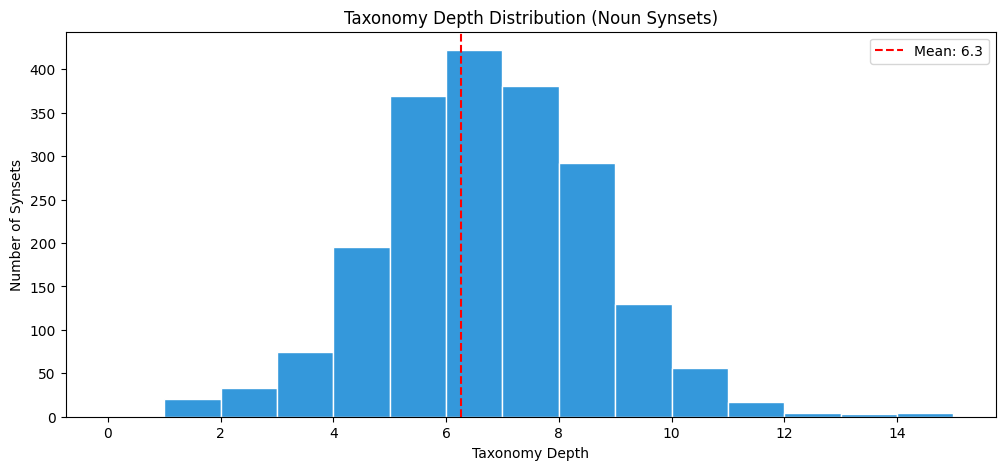

In [13]:
# Taxonomy depth analysis
def get_depth(ss, max_depth=20):
    if max_depth <= 0:
        return 999
    hypernyms = ss.hypernyms()
    if not hypernyms:
        return 0
    return 1 + min(get_depth(h, max_depth-1) for h in hypernyms)

# Sample nouns for depth analysis
noun_synsets = [ss for ss in synsets if ss.pos == 'n' and ss.hypernyms()]
depths = [get_depth(ss) for ss in noun_synsets[:2000]]

print(f"\nTaxonomy Depth Statistics (sample of {len(depths)} nouns):")
print(f"  Average depth: {sum(depths)/len(depths):.2f}")
print(f"  Max depth: {max(depths)}")
print(f"  Min depth: {min(depths)}")

# Visualize
plt.figure(figsize=(12, 5))
plt.hist(depths, bins=range(max(depths)+2), edgecolor='white', color='#3498db')
plt.xlabel('Taxonomy Depth')
plt.ylabel('Number of Synsets')
plt.title('Taxonomy Depth Distribution (Noun Synsets)')
plt.axvline(x=sum(depths)/len(depths), color='red', linestyle='--', label=f'Mean: {sum(depths)/len(depths):.1f}')
plt.legend()
plt.show()

---
## 5. Duplicate Detection

In [14]:
print("=" * 70)
print("DUPLICATE DETECTION")
print("=" * 70)

# Find lemmas appearing in multiple synsets
lemma_to_synsets = defaultdict(list)
for ss in synsets:
    for word in ss.words():
        lemma_to_synsets[word.lemma()].append(ss)

# Check for potential duplicates (same lemma, similar definition)
potential_duplicates = []

for lemma, ss_list in lemma_to_synsets.items():
    if len(ss_list) >= 2:
        for i, ss1 in enumerate(ss_list):
            for ss2 in ss_list[i+1:]:
                def1 = ss1.definition() or ""
                def2 = ss2.definition() or ""
                if def1 and def2 and len(def1) > 20:
                    # Check for very similar definitions
                    if def1 == def2 or def1 in def2 or def2 in def1:
                        potential_duplicates.append({
                            'lemma': lemma,
                            'synset1_id': ss1.id,
                            'synset1_def': def1[:80],
                            'synset2_id': ss2.id,
                            'synset2_def': def2[:80]
                        })

print(f"\nPotential duplicate synsets: {len(potential_duplicates)}")
dup_df = pd.DataFrame(potential_duplicates)
dup_df.to_csv('exports/potential_duplicates.csv', index=False)
display(dup_df)

DUPLICATE DETECTION

Potential duplicate synsets: 10


,lemma,synset1_id,synset1_def,synset2_id,synset2_def
0,مُغَادَرَة,awn3-00043495-n,عملية ترك المكان إلى مكان آخر,awn3-00059339-n,عملية ترك المكان إلى مكان آخر
1,قَتْل,awn3-00219879-n,عملية إنهاء حياة كائن حي,awn3-00220442-n,عملية إنهاء حياة كائن حي
2,نَحْت,awn3-00941268-n,فن تجسيدي يعتمد على إنشاء مجسمات ثلاثية الأبعاد,awn3-04164381-n,فن تجسيدي يعتمد على إنشاء مجسمات ثلاثية الأبعا...
3,عَدَم,awn3-13983104-n,ضد الوجود، عدم كينونة، حالة ما هو غير كائن,awn3-14479148-n,عدم كينونة، حالة ما هو غير كائن
4,كَسَرَ,awn3-00107543-v,يكسر عظمة في جسده أثناء نشاط ما,awn3-00107747-v,يكسر عظمة
5,أَسْرَعَ,awn3-00460453-v,يتصرف أو يتحرك بسرعة كبيرة,awn3-02059573-v,يتحرك بسرعة كبيرة
6,حَصَلَ عَلَى,awn3-02215637-v,يصبح مالكاً لشيء مادي أو معنوي,awn3-02242867-v,يصبح مالكاً ل
7,شَغَّلَ,awn3-01227308-v,يُشغل الشيء ويجعله يعمل,awn3-02413117-v,يجعله يعمل
8,شَغَّلَ,awn3-01513031-v,يجعله يعمل بالضغط على زر أو ما شابه,awn3-02413117-v,يجعله يعمل
9,دَارَ,awn3-02048992-v,يدور حول محور أو مركز,awn3-02100445-v,يدور حول محور أو مركز ثابت


---
## 6. Linguistic Issues

In [15]:
print("=" * 70)
print("LINGUISTIC ISSUES ANALYSIS")
print("=" * 70)

# Check for diacritization variants
diacritic_pattern = re.compile(r'[\u064B-\u065F\u0670]')

lemma_without_diacritics = defaultdict(list)
for word in words:
    lemma = word.lemma()
    clean = diacritic_pattern.sub('', lemma)
    lemma_without_diacritics[clean].append({
        'form': lemma,
        'pos': word.pos,
        'synsets': [s.synset().id for s in word.senses()[:3]]
    })

# Find words with multiple diacritization forms
diacritic_variants = {}
for base, variants in lemma_without_diacritics.items():
    unique_forms = list(set([v['form'] for v in variants]))
    if len(unique_forms) > 1:
        diacritic_variants[base] = variants

print(f"\nWords with diacritization variants: {len(diacritic_variants)}")
print("\nSample variants:")
for base, variants in list(diacritic_variants.items())[:10]:
    unique_forms = list(set([v['form'] for v in variants]))
    print(f"  {base}: {unique_forms[:5]}")

LINGUISTIC ISSUES ANALYSIS

Words with diacritization variants: 1192

Sample variants:
  مثال: ['مِثَال', 'مِثال']
  جزء: ['جِزْء', 'جُزُء', 'جُزْء']
  قسم: ['قَسَم', 'قَسَّمَ', 'قِسْم', 'قِسْمَ']
  مكون: ['مكوِّن', 'مُكَوِّن']
  فعل: ['فِعْل', 'فعل']
  ميزة: ['مِيزَة', 'مِيْزَة']
  خاصية: ['خَاصِيَّة', 'خَاصِّيَّة', 'خَاصّيَّة', 'خاصية']
  سبب: ['سبب', 'سَبَّبَ', 'سَبَب']
  تجريد: ['تَجْريد', 'تَجْرِيد', 'تجريد']
  شيء: ['شيء', 'شَيء']


In [16]:
# Large synsets (potential lumping issues)
large_synsets = [(ss, len(ss.words())) for ss in synsets if len(ss.words()) > 5]
large_synsets.sort(key=lambda x: -x[1])

print(f"\nLarge synsets (>5 words): {len(large_synsets)}")
print("\nThese may need review for potential over-lumping:")

large_df = pd.DataFrame([
    {
        'synset_id': ss.id,
        'pos': ss.pos,
        'word_count': size,
        'words': ', '.join([w.lemma() for w in ss.words()[:10]]),
        'definition': (ss.definition() or '')[:60]
    }
    for ss, size in large_synsets[:30]
])
large_df.to_csv('exports/large_synsets.csv', index=False)
display(large_df.head(15))


Large synsets (>5 words): 60

These may need review for potential over-lumping:


,synset_id,pos,word_count,words,definition
0,awn3-02065423-v,v,50,"اِنْطلق بِسُرْعة, اِنْطلق بِسُرْعة البرْق, اِن...",يجري أو يتحرك بسرعة كبيرة
1,awn3-01005294-v,v,49,"أخذ لقْطة, صوّر, صوّر فُوتُوغرافِيًّا, أخذ صور...",يلتقط صوراً ويسجلها على شريط فوتوغرافي
2,awn3-00058790-v,v,47,"إِنْتظر, حملتْ, تنْتظِرُ موْلُوداً, ترقّب, توق...",تحمل مولوداً وتنتظر قدومه
3,awn3-01429048-v,v,45,"اِتّصل جِنْسِيّاً, ضاجع, جامع, نام مع, نكح, أص...",يكون له علاقة جنسية مع شخص آخر
4,awn3-02324030-v,v,42,"أبْهظ, أرْهق, غلّى, نهب, سلب, أثقل, أخذ بدون ح...",يطلب سعراً أو مبلغاً غير منطقي
5,awn3-02180712-v,v,36,"أصْدر صوْت, أدى, أصبح, أعلن, أمر, إستطلع الآرا...",يحدث صوتاً أو ضجيجاً معيناً
6,awn3-01480632-v,v,35,"أعاق, أقام حاجِزا, سدّ, أحبط, أربك, أقام مؤقتا...",يقيم حاجزاً غير مناسب يمنع فيه الناس من المرور...
7,awn3-01815703-v,v,27,"أنْهض, اِسْتنْهض, حفّز, حرّك, رفع, رفع المعْنو...",يجعل الشخص أسعد ويملؤه بالأمل
8,awn3-00238145-v,v,23,"أنْقص بِالغلْي, اِسْتخْلص بِالغلْي, أصبح أشد ق...",يبقى على النار في حالة الغليان حتى ينقص السائل...
9,awn3-02307797-v,v,23,"باع, باع مُتجوِّلا, أذاع, أعطى النغمة, أقام مع...",يقوم ببيع بضاعته متنقلاً من مكان لآخر ( وليس ض...


---
## 7. Cross-lingual Alignment Issues

In [17]:
print("=" * 70)
print("CROSS-LINGUAL ALIGNMENT ANALYSIS")
print("=" * 70)

# Check for definition length mismatches
alignment_issues = []

for ss in synsets:
    if not ss.ili:
        continue
    
    ili_id = ss.ili.id
    if ili_id not in oewn_ili_map:
        continue
    
    oewn_ss = oewn_ili_map[ili_id]
    ar_def = ss.definition() or ""
    en_def = oewn_ss.definition() or ""
    
    if ar_def and en_def:
        len_ratio = len(ar_def) / len(en_def) if len(en_def) > 0 else 0
        if len_ratio < 0.3 or len_ratio > 3:
            alignment_issues.append({
                'synset_id': ss.id,
                'ar_words': ', '.join([w.lemma() for w in ss.words()[:3]]),
                'en_words': ', '.join([w.lemma() for w in oewn_ss.words()[:3]]),
                'ar_def_len': len(ar_def),
                'en_def_len': len(en_def),
                'ratio': round(len_ratio, 2),
                'ar_def': ar_def[:80],
                'en_def': en_def[:80]
            })

print(f"\nDefinition length mismatches: {len(alignment_issues)}")
alignment_df = pd.DataFrame(alignment_issues)
alignment_df.to_csv('exports/alignment_issues.csv', index=False)
display(alignment_df.head(15))

CROSS-LINGUAL ALIGNMENT ANALYSIS

Definition length mismatches: 387


,synset_id,ar_words,en_words,ar_def_len,en_def_len,ratio,ar_def,en_def
0,awn3-00007846-n,"شَخْص, أَحَد, فَرْد","person, individual, someone",35,124,0.28,كلمة تدل على الكائن البشري، الإنسان,"a human being; person, singular, assertive exi..."
1,awn3-00033122-n,عَلاقَة إجْتِمَاعِيَّة,social relation,18,63,0.29,الرابط بين الأشخاص,a relation between living organisms (especiall...
2,awn3-00034778-n,عمل,thing,37,9,4.11,تعبيرسلبي للإشارة إلى عمل سييء أو صعب,an action
3,awn3-00044640-n,ضَرْبَة,hit,48,161,0.30,الضربة الموفقة في الرياضة (بالأخص كرة البيسبول ),(baseball) when a batter strikes a pitched bal...
4,awn3-00044888-n,"تَنْفِيذ, تَطْبِيق","implementation, effectuation",18,103,0.17,عملية تفعيل خطة ما,the act of implementing (providing a practical...
5,awn3-00050857-n,"اِنْخِرَاط, تَسْجِيل","registration, enrollment, enrolment",80,20,4.00,عملية الانضمام أو الالتحاق بمجال رسمي والاشتغا...,the act of enrolling
6,awn3-00082392-n,خيار الشراء,"buying, purchasing",70,17,4.12,خيار الشراء هو عقد يسمح لحامله بشراء أصل ما خل...,the act of buying
7,awn3-00232434-n,إِبْطَال مفعول,"nullification, override",31,105,0.30,عملية إلغاء تأثير أو قوة شيء ما,the act of nullifying; making null and void; c...
8,awn3-00304675-n,قِيَادَة,"jump, parachuting",76,24,3.17,عملية التحكم بتسيير المركبة كالسيارة والشاحنة ...,descent with a parachute
9,awn3-00316812-n,"السَفَر بالبَحْر, السَفَر بَحْرَاً","transportation, transport, transfer",15,56,0.27,السفر عبر البحر,the act of moving something from one location ...


In [18]:
# Check for synsets without ILI
no_ili_synsets = [ss for ss in synsets if not ss.ili]
print(f"\nSynsets without ILI link: {len(no_ili_synsets)}")

no_ili_df = pd.DataFrame([
    {
        'synset_id': ss.id,
        'pos': ss.pos,
        'words': ', '.join([w.lemma() for w in ss.words()[:3]]),
        'definition': (ss.definition() or '')[:80]
    }
    for ss in no_ili_synsets
])
no_ili_df.to_csv('exports/no_ili_synsets.csv', index=False)
display(no_ili_df)


Synsets without ILI link: 28


,synset_id,pos,words,definition
0,awn3-00951435-n,n,تَطْبِيق,نقل شيء ما إلى التنفيذ بشكل عملي ، واستخدامه ل...
1,awn3-03739038-n,n,"واسِطَة, وَسِيلَة",أداة لإنجاز شيء ما بواسطتها
2,awn3-05694760-n,n,صُعُوبَة,عامل يسبب مشكلة في تحقيق نتيجة إيجابية أو يميل...
3,awn3-06631572-n,n,"اِسْتِعْرَاض, عَرْض",حدث اجتماعي يتضمن أداء شعبياً لمختلف الفنون
4,awn3-00811359-n,n,هِنْدُوسِيَّة,الديانة السائدة في الهند وتتميز بعبادة العديد ...
5,awn3-08269132-n,n,لِقاء اِجْتِماعِيّ,تجمع لغرض تعزيز الزمالة بين الأشخاص
6,awn3-08517241-n,n,"أعْمَاق, عُمْق",أبعد وأعمق منطقة
7,awn3-14431490-n,n,صُعُوبَة,حالة من الضيق والحرج والعناء في أمر يحتاج إلى ...
8,awn3-00065266-v,v,,يكون بصحة جيدة ولا يشتكي من الأمراض
9,awn3-00078154-v,v,عَانَى,يشعر بأنه في حال سيئة وغير مرتاح


---
## 8. Sample Issues for Manual Review

In [19]:
import random

print("=" * 70)
print("RANDOM SAMPLE FOR MANUAL REVIEW")
print("=" * 70)

# Create a stratified random sample
sample_data = []

for pos in ['n', 'v', 'a', 'r']:
    pos_synsets = [ss for ss in synsets if ss.pos == pos and ss.words()]
    sample_size = min(25, len(pos_synsets))
    sample = random.sample(pos_synsets, sample_size)
    
    for ss in sample:
        # Get English equivalent if available
        en_words = []
        en_def = ""
        if ss.ili and ss.ili.id in oewn_ili_map:
            oewn_ss = oewn_ili_map[ss.ili.id]
            en_words = [w.lemma() for w in oewn_ss.words()[:3]]
            en_def = oewn_ss.definition() or ""
        
        sample_data.append({
            'synset_id': ss.id,
            'pos': ss.pos,
            'ar_words': ', '.join([w.lemma() for w in ss.words()[:5]]),
            'ar_definition': ss.definition() or '',
            'ar_example': ss.examples()[0] if ss.examples() else '',
            'en_words': ', '.join(en_words),
            'en_definition': en_def[:150],
            'has_hypernym': bool(ss.hypernyms()),
            'review_notes': ''  # For manual annotation
        })

sample_df = pd.DataFrame(sample_data)
sample_df.to_csv('exports/manual_review_sample.csv', index=False)
print(f"\nExported {len(sample_df)} synsets for manual review")
display(sample_df.head(10))

RANDOM SAMPLE FOR MANUAL REVIEW

Exported 100 synsets for manual review


,synset_id,pos,ar_words,ar_definition,ar_example,en_words,en_definition,has_hypernym,review_notes
0,awn3-14015308-n,n,حُرِّيَّة,حالة شخص لا يكون تابعاً لأحد، وإمكانيته ممارسة...,الحرية خلاص الإنسان من كل سيطرة تتحكم فيه,freedom,the condition of being free; the power to act ...,True,
1,awn3-03541528-n,n,سَطْح أُفُقِي,سطح منبسط بزاوية قائمة على خط رأسي,يجب تثبيت الأجهزة على سطح منبسط حتى لا تتضرر.,"horizontal surface, level",a flat surface at right angles to a plumb line,True,
2,awn3-06492177-n,n,وَسِيلَة إشْتِقاق,أدوات مالية تستمد قيمتها من أصل مالي آخر، اتفا...,العقود الآجلة هي مثال عن المشتقات المالية/ وسا...,"derivative instrument, derivative",a financial instrument whose value is based on...,True,
3,awn3-03003851-n,n,دِرْع مِن جنْزِير,(في العصور الوسطى): درع مرن مصنوع من الحلقات ا...,يسمح درع الجنزير المرن لمرتديه بمجال من الحركة,"chain mail, ring mail, mail",(Middle Ages) flexible armor made of interlink...,True,
4,awn3-03656591-n,n,رَقِيقَة فَاصِلَة,شريط رفيع من المعدن يستخدم لفصل خطوط الكتابة أ...,الفواصل الرقيقة تستخدم لإنشاء المسافة العمودية...,"lead, leading",thin strip of metal used to separate lines of ...,True,
5,awn3-03930191-n,n,أسْطُوَانَة فُونُوغرَافِيَّة,قرص دائري به أخاديد حلزونية مركزية بأحجام مختل...,رغم انتهاء عصر الأسطوانات الفونوغرافية إلا أنه...,"phonograph record, phonograph recording, record",sound recording consisting of a disk with a co...,True,
6,awn3-06399623-n,n,"نَصّ, مادة نصية",الكلمات المكتوبة في نص ما، ( خلافاً للصور والر...,طلب المعلم كتابة نص عن جمال البحر لا يزيد عن ا...,"text, textual matter",the words of something written,True,
7,awn3-08069626-n,n,السُلْطَة المَحَلِّيَّة,هيئة إدارية مسؤولة عن منطقة جغرافية صغيرة في ا...,الطرق والنقل هي مسؤولية السلطة المحلية في المدينة,local government,the government of a local area,True,
8,awn3-15004774-n,n,مُبِيد,مادة كيميائية تستخدم لقتل الآفات كالقوارض والح...,كثرة استخدام المبيدات يمكن أن تكون ضارة للإنسان,pesticide,a chemical used to kill pests (as rodents or i...,True,
9,awn3-00065324-n,n,"ضَرْبَة نجاح, نَجَاح بَاهِر",إنجاز يُعرف وينتشر على نطاق واسع,كانت الأغنية أول ضربة نجاح له في بداياته. حقق ...,"hit, smash, smasher",a conspicuous success,True,


---
## Summary

In [ ]:
print("=" * 80)
print("AWN3 ISSUES SUMMARY")
print("=" * 80)

summary = f"""
╔══════════════════════════════════════════════════════════════════════════════╗
║                    AWN3 QUALITY ISSUES SUMMARY                                ║
╚══════════════════════════════════════════════════════════════════════════════╝

CRITICAL ISSUES
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Empty synsets (no words):                {len(empty_synsets):>8}
  Missing definitions:                     {len(missing_definition):>8}
  No ILI link:                             {len(no_ili):>8}
  Potential duplicates:                    {len(potential_duplicates):>8}

DEFINITION QUALITY
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Too short (<15 chars):                   {len(definition_issues['too_short']):>8}
  Circular (contains lemma):               {len(definition_issues['circular']):>8}
  Contains English:                        {len(definition_issues['has_english']):>8}

EXAMPLE QUALITY
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Missing examples:                        {len(example_issues['missing']):>8}
  Too short (<15 chars):                   {len(example_issues['too_short']):>8}

STRUCTURAL ISSUES
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Orphan synsets (total):                  {len(orphans):>8}
    - Orphan nouns:                        {len(orphan_nouns):>8}  (unexpected)
    - Orphan verbs:                        {len(orphan_verbs):>8}  (unexpected)
  Large synsets (>5 words):                {len(large_synsets):>8}

CROSS-LINGUAL
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Definition length mismatches:            {len(alignment_issues):>8}
  Diacritization variants:                 {len(diacritic_variants):>8}

EXPORTED FILES
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  exports/empty_synsets.csv
  exports/missing_definitions.csv
  exports/short_definitions.csv
  exports/circular_definitions.csv
  exports/short_examples.csv
  exports/orphan_nouns.csv
  exports/orphan_verbs.csv
  exports/potential_duplicates.csv
  exports/large_synsets.csv
  exports/alignment_issues.csv
  exports/no_ili_synsets.csv
  exports/manual_review_sample.csv
"""
print(summary)

---
## Recommendations

Based on this analysis, here are the recommended actions:

### High Priority
1. **Fill empty synsets** - 14 synsets have definitions but no Arabic words
2. **Add missing definitions** - 252 synsets lack definitions
3. **Review potential duplicates** - 10 synsets may be duplicates

### Medium Priority
4. **Connect orphan nouns/verbs** - 141 nouns and 58 verbs lack hypernyms
5. **Expand short definitions** - 129 definitions are too brief
6. **Fix circular definitions** - 52 definitions contain the word being defined

### Low Priority
7. **Review large synsets** - 60 synsets have >5 words (potential over-lumping)
8. **Add missing examples** - 313 synsets lack examples
9. **Check alignment issues** - 139 synsets have definition length mismatches

### Notes
- Orphan adjectives (446) and adverbs (107) are expected - they use similarity relations
- Nouns with verb-like definitions (547) are often masdar (verbal nouns) - linguistically correct
- Diacritization variants (2,181) often represent legitimate different words